In [1]:
!pip install segmentation_models_pytorch warmup_scheduler albumentations -q


In [2]:
import os
import sys
import random
from glob import glob
import warnings

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

sys.path.append('/kaggle/working/notebook/experiment/2d')
from script.helper import *
from script.dataset import *
from script.metrics import *
from script.trainer import *
from script.model import *
from script.loss import *
from script.scheduler import *


## config

In [3]:
class ExtractLayers(A.ImageOnlyTransform):
    def __init__(self, in_channels, out_channels, is_train=True, always_apply=False, p=1):
        super(ExtractLayers, self).__init__(always_apply, p)
        self.is_train = is_train
        self.in_channels = in_channels
        self.out_channels = out_channels

    def apply(self, img, **params):
        if self.is_train:
            start = random.randint(0, self.in_channels-self.out_channels)
            end = start+self.out_channels
            img = img[:, :, start:end]
        else:
            img = img[:, :, 4:4+self.out_channels]
        return img


In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'
    comp_dir_path = '/kaggle/input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'

    dataset_path = "/kaggle/working/dataset_train/"
    train_dataset_path = "/kaggle/working/dataset_train/nonflatten/25-37/"
    dataset_range = train_dataset_path.split("/")[-2]
    
    exp_name = os.getcwd().split('/')[-1]

    # ============== model cfg =============
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'
    in_chans = 6

    # ============== pred target =============
    target_size = 1

    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16  # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'

    epochs = 25  # 15

    warmup_factor = 10
    lr = 1e-4 / warmup_factor
    loss="bce_dice_loss"
    # ============== fold =============
    metric_direction = 'maximize'  # maximize, 'minimize'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== augmentation =============
    train_aug_list = [
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.125, p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 60]),
                A.GaussianBlur(),
                A.MotionBlur(blur_limit=9),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.35, p=0.5),
        A.CoarseDropout(max_holes=8, max_width=int(size * 0.3), max_height=int(size * 0.3),
                        mask_fill_value=0, p=0.5),
        ExtractLayers(13, 6, is_train=True),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        ExtractLayers(13, 6, is_train=False),
        A.Normalize(
            mean=[0] * in_chans,
            std=[1] * in_chans,
            max_pixel_value=65535,
        ),
        ToTensorV2(transpose_mask=True),
    ]


warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True  # type: ignore

set_seed(CFG.seed)
os.makedirs(f'./{CFG.exp_name}/', exist_ok=True)


## Dataset

In [5]:
def preprocess(image, fragment_i, split_i):
    # topography = cv2.imread(f"{CFG.dataset_path}/topography_{fragment_i}_{split_i}.png",-1)
    # topography = topography.astype("uint16")*1057
    # pad0 = (CFG.tile_size - topography.shape[0] % CFG.tile_size)
    # pad1 = (CFG.tile_size - topography.shape[1] % CFG.tile_size)
    # topography = np.pad(topography, [(0, pad0), (0, pad1)], constant_values=0)
    # topography = np.expand_dims(topography, axis=2)
    # image=np.concatenate([image,topography], axis=2)
    return image



len(train_images) = 14624
train_images[0].shape = (224, 224, 13)
train_labels[0].shape = (224, 224, 1)
train_masks[0].shape = (224, 224, 1)

len(valid_images) = 4161
valid_images[0].shape = (224, 224, 13)
valid_labels[0].shape = (224, 224, 1)



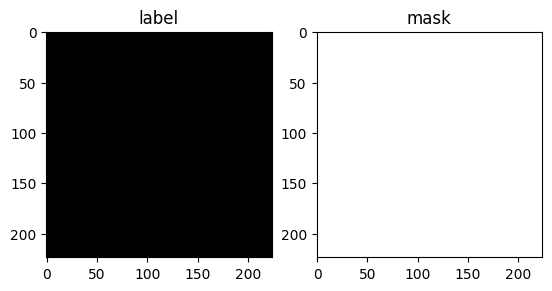

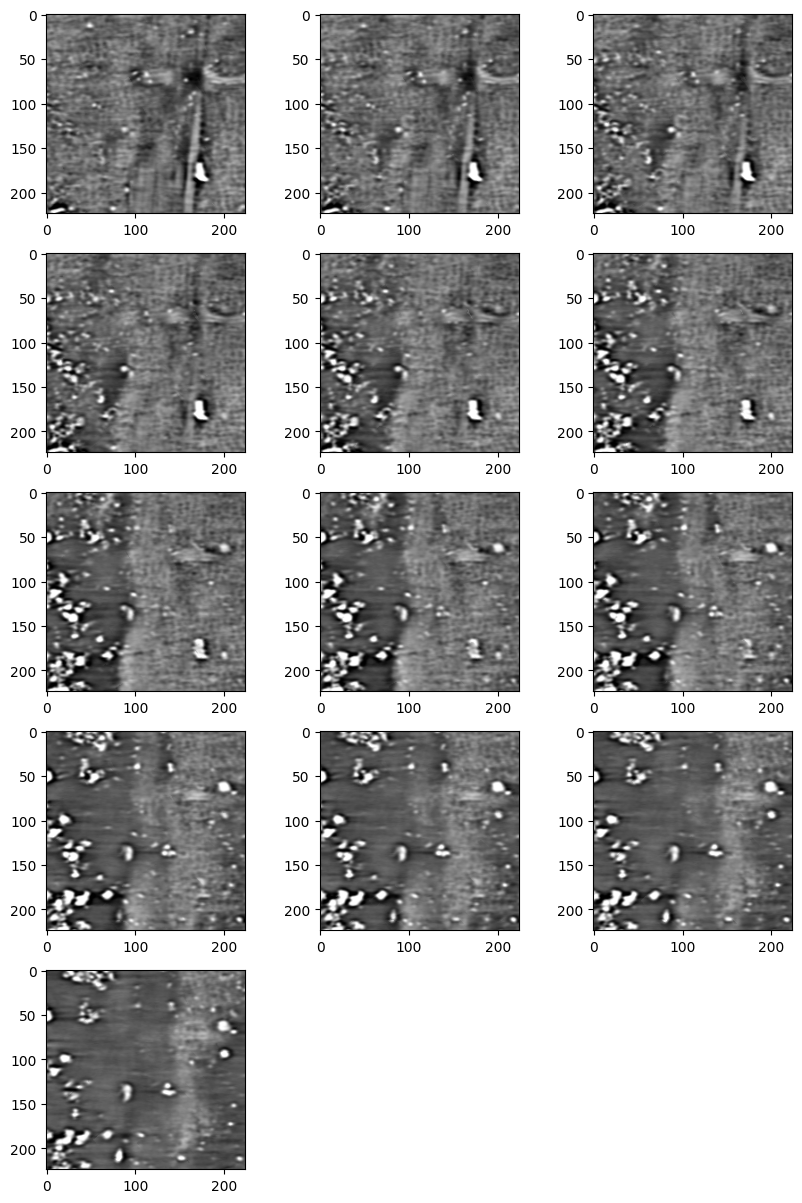

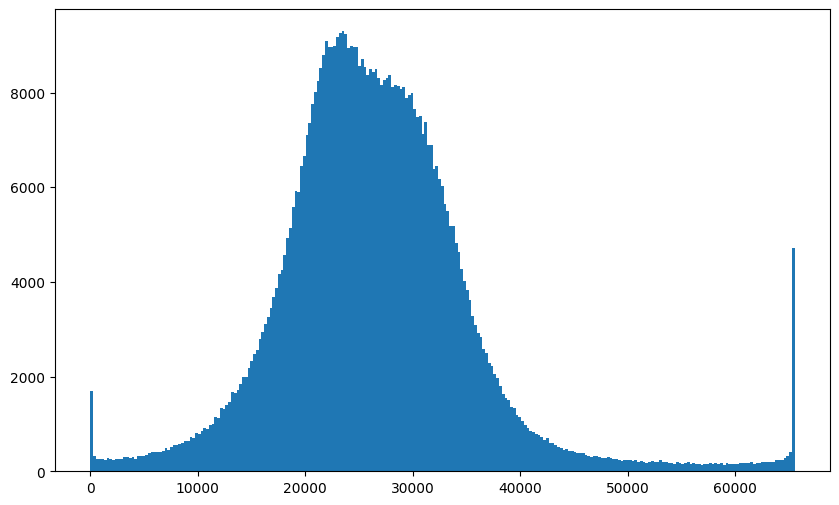

In [6]:
# confirmation

valid_fragment_i = 1
valid_split_i = 0

train_images, train_labels, train_masks, valid_images, valid_labels, valid_xyxys = get_train_valid_dataset(valid_fragment_i, valid_split_i, CFG, preprocess)

print(f"""
{len(train_images) = }
{train_images[0].shape = }
{train_labels[0].shape = }
{train_masks[0].shape = }

{len(valid_images) = }
{valid_images[0].shape = }
{valid_labels[0].shape = }
""")

id = random.randint(0, len(train_labels))
visualize_train_images(id, train_images, train_labels, train_masks)


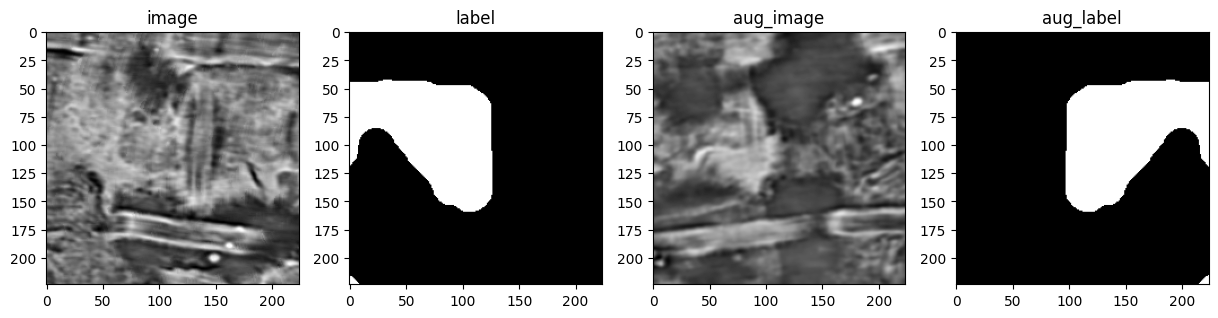

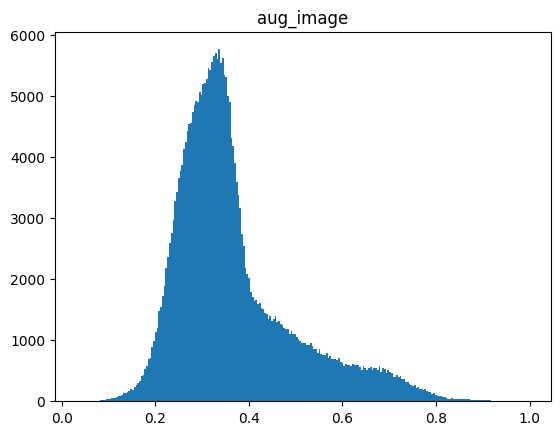

In [7]:
# confirmation
plot_dataset = CustomDataset(train_images, CFG, labels=train_labels)
visualize_dataset(plot_dataset, CFG)


## main

In [8]:
train_and_evaluate(preprocess, CFG)
!curl -X POST -H 'Authorization: Bearer '$LINE -F 'message=セルの実行が終わりました！' https://notify-api.line.me/api/notify

fold: 0


100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 16.65it/s]


fbeta: 0.3230
Epoch 1 - avg_train_loss: 1.4346  avg_val_loss: 1.1571  avgScore: 0.3230  time: 85s
Epoch 1 - Save Best Loss: 1.1571  Best Score: 0.3230 Model



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 17.99it/s]


fbeta: 0.4077
Epoch 2 - avg_train_loss: 1.2032  avg_val_loss: 1.0272  avgScore: 0.4077  time: 78s
Epoch 2 - Save Best Loss: 1.0272  Best Score: 0.4077 Model



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.07it/s]


fbeta: 0.3240
Epoch 3 - avg_train_loss: 1.0253  avg_val_loss: 1.0802  avgScore: 0.3240  time: 79s



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.09it/s]


fbeta: 0.3942
Epoch 4 - avg_train_loss: 0.9225  avg_val_loss: 0.9307  avgScore: 0.3942  time: 78s



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.13it/s]


fbeta: 0.4211
Epoch 5 - avg_train_loss: 0.8865  avg_val_loss: 0.9053  avgScore: 0.4211  time: 78s
Epoch 5 - Save Best Loss: 0.9053  Best Score: 0.4211 Model



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.08it/s]


fbeta: 0.3846
Epoch 6 - avg_train_loss: 0.8799  avg_val_loss: 0.9914  avgScore: 0.3846  time: 78s



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.14it/s]


fbeta: 0.4964
Epoch 7 - avg_train_loss: 0.8513  avg_val_loss: 0.9222  avgScore: 0.4964  time: 78s
Epoch 7 - Save Best Loss: 0.9222  Best Score: 0.4964 Model



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.04it/s]


fbeta: 0.4027
Epoch 8 - avg_train_loss: 0.8202  avg_val_loss: 0.9376  avgScore: 0.4027  time: 79s



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.04it/s]


fbeta: 0.4425
Epoch 9 - avg_train_loss: 0.8254  avg_val_loss: 0.9585  avgScore: 0.4425  time: 78s



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.08it/s]


fbeta: 0.4051
Epoch 10 - avg_train_loss: 0.8109  avg_val_loss: 1.0856  avgScore: 0.4051  time: 78s



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.12it/s]


fbeta: 0.4526
Epoch 11 - avg_train_loss: 0.7953  avg_val_loss: 0.8879  avgScore: 0.4526  time: 78s



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.17it/s]


fbeta: 0.5132
Epoch 12 - avg_train_loss: 0.7893  avg_val_loss: 0.8713  avgScore: 0.5132  time: 79s
Epoch 12 - Save Best Loss: 0.8713  Best Score: 0.5132 Model



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.05it/s]


fbeta: 0.4357
Epoch 13 - avg_train_loss: 0.7668  avg_val_loss: 0.9106  avgScore: 0.4357  time: 78s



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.11it/s]


fbeta: 0.5363
Epoch 14 - avg_train_loss: 0.7579  avg_val_loss: 0.8991  avgScore: 0.5363  time: 78s
Epoch 14 - Save Best Loss: 0.8991  Best Score: 0.5363 Model



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.09it/s]


fbeta: 0.4342
Epoch 15 - avg_train_loss: 0.7511  avg_val_loss: 0.8941  avgScore: 0.4342  time: 79s



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.15it/s]


fbeta: 0.4109
Epoch 16 - avg_train_loss: 0.7386  avg_val_loss: 0.9413  avgScore: 0.4109  time: 78s



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.13it/s]


fbeta: 0.4735
Epoch 17 - avg_train_loss: 0.7280  avg_val_loss: 0.8910  avgScore: 0.4735  time: 79s



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.11it/s]


fbeta: 0.4555
Epoch 18 - avg_train_loss: 0.7174  avg_val_loss: 0.9210  avgScore: 0.4555  time: 79s



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.14it/s]


fbeta: 0.5079
Epoch 19 - avg_train_loss: 0.7040  avg_val_loss: 0.8723  avgScore: 0.5079  time: 78s



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.10it/s]


fbeta: 0.5177
Epoch 20 - avg_train_loss: 0.6996  avg_val_loss: 0.8708  avgScore: 0.5177  time: 78s



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 17.98it/s]


fbeta: 0.5201
Epoch 21 - avg_train_loss: 0.6857  avg_val_loss: 0.8679  avgScore: 0.5201  time: 79s



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.11it/s]


fbeta: 0.5413
Epoch 22 - avg_train_loss: 0.6844  avg_val_loss: 0.8662  avgScore: 0.5413  time: 78s
Epoch 22 - Save Best Loss: 0.8662  Best Score: 0.5413 Model



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.06it/s]


fbeta: 0.5029
Epoch 23 - avg_train_loss: 0.6879  avg_val_loss: 0.8897  avgScore: 0.5029  time: 78s



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.06it/s]


fbeta: 0.5232
Epoch 24 - avg_train_loss: 0.6774  avg_val_loss: 0.8749  avgScore: 0.5232  time: 78s



100%|█████████████████████████████████████████| 131/131 [00:07<00:00, 18.07it/s]


fbeta: 0.5231
Epoch 25 - avg_train_loss: 0.6657  avg_val_loss: 0.8821  avgScore: 0.5231  time: 78s

fold: 1


100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.34it/s]


fbeta: 0.1622
Epoch 1 - avg_train_loss: 1.5438  avg_val_loss: 1.0344  avgScore: 0.1622  time: 82s
Epoch 1 - Save Best Loss: 1.0344  Best Score: 0.1622 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.49it/s]


fbeta: 0.3832
Epoch 2 - avg_train_loss: 1.2604  avg_val_loss: 0.8378  avgScore: 0.3832  time: 80s
Epoch 2 - Save Best Loss: 0.8378  Best Score: 0.3832 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.71it/s]


fbeta: 0.4101
Epoch 3 - avg_train_loss: 1.0496  avg_val_loss: 0.6770  avgScore: 0.4101  time: 79s
Epoch 3 - Save Best Loss: 0.6770  Best Score: 0.4101 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.76it/s]


fbeta: 0.4630
Epoch 4 - avg_train_loss: 0.9415  avg_val_loss: 0.6349  avgScore: 0.4630  time: 79s
Epoch 4 - Save Best Loss: 0.6349  Best Score: 0.4630 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.72it/s]


fbeta: 0.4188
Epoch 5 - avg_train_loss: 0.9097  avg_val_loss: 0.6356  avgScore: 0.4188  time: 81s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.74it/s]


fbeta: 0.4683
Epoch 6 - avg_train_loss: 0.8640  avg_val_loss: 0.6394  avgScore: 0.4683  time: 79s
Epoch 6 - Save Best Loss: 0.6394  Best Score: 0.4683 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.75it/s]


fbeta: 0.5113
Epoch 7 - avg_train_loss: 0.8678  avg_val_loss: 0.6472  avgScore: 0.5113  time: 80s
Epoch 7 - Save Best Loss: 0.6472  Best Score: 0.5113 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.73it/s]


fbeta: 0.4699
Epoch 8 - avg_train_loss: 0.8343  avg_val_loss: 0.6217  avgScore: 0.4699  time: 79s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.72it/s]


fbeta: 0.4850
Epoch 9 - avg_train_loss: 0.8097  avg_val_loss: 0.6308  avgScore: 0.4850  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.77it/s]


fbeta: 0.5086
Epoch 10 - avg_train_loss: 0.8090  avg_val_loss: 0.6159  avgScore: 0.5086  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.78it/s]


fbeta: 0.5467
Epoch 11 - avg_train_loss: 0.7747  avg_val_loss: 0.6005  avgScore: 0.5467  time: 80s
Epoch 11 - Save Best Loss: 0.6005  Best Score: 0.5467 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.67it/s]


fbeta: 0.5796
Epoch 12 - avg_train_loss: 0.7717  avg_val_loss: 0.5758  avgScore: 0.5796  time: 79s
Epoch 12 - Save Best Loss: 0.5758  Best Score: 0.5796 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.76it/s]


fbeta: 0.5507
Epoch 13 - avg_train_loss: 0.7643  avg_val_loss: 0.5835  avgScore: 0.5507  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.71it/s]


fbeta: 0.5680
Epoch 14 - avg_train_loss: 0.7458  avg_val_loss: 0.5954  avgScore: 0.5680  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.69it/s]


fbeta: 0.5739
Epoch 15 - avg_train_loss: 0.7371  avg_val_loss: 0.5837  avgScore: 0.5739  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.89it/s]


fbeta: 0.5646
Epoch 16 - avg_train_loss: 0.7260  avg_val_loss: 0.5765  avgScore: 0.5646  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.70it/s]


fbeta: 0.5849
Epoch 17 - avg_train_loss: 0.7155  avg_val_loss: 0.5931  avgScore: 0.5849  time: 80s
Epoch 17 - Save Best Loss: 0.5931  Best Score: 0.5849 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.68it/s]


fbeta: 0.5808
Epoch 18 - avg_train_loss: 0.6982  avg_val_loss: 0.5702  avgScore: 0.5808  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.69it/s]


fbeta: 0.5875
Epoch 19 - avg_train_loss: 0.6790  avg_val_loss: 0.5805  avgScore: 0.5875  time: 80s
Epoch 19 - Save Best Loss: 0.5805  Best Score: 0.5875 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.61it/s]


fbeta: 0.6165
Epoch 20 - avg_train_loss: 0.6702  avg_val_loss: 0.5601  avgScore: 0.6165  time: 80s
Epoch 20 - Save Best Loss: 0.5601  Best Score: 0.6165 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.76it/s]


fbeta: 0.5954
Epoch 21 - avg_train_loss: 0.6679  avg_val_loss: 0.5684  avgScore: 0.5954  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.78it/s]


fbeta: 0.6020
Epoch 22 - avg_train_loss: 0.6672  avg_val_loss: 0.5778  avgScore: 0.6020  time: 79s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.73it/s]


fbeta: 0.6049
Epoch 23 - avg_train_loss: 0.6608  avg_val_loss: 0.5692  avgScore: 0.6049  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.67it/s]


fbeta: 0.5940
Epoch 24 - avg_train_loss: 0.6475  avg_val_loss: 0.5751  avgScore: 0.5940  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.73it/s]


fbeta: 0.5930
Epoch 25 - avg_train_loss: 0.6378  avg_val_loss: 0.5788  avgScore: 0.5930  time: 79s

fold: 2


100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.70it/s]


fbeta: 0.3396
Epoch 1 - avg_train_loss: 1.1651  avg_val_loss: 1.1926  avgScore: 0.3396  time: 80s
Epoch 1 - Save Best Loss: 1.1926  Best Score: 0.3396 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.26it/s]


fbeta: 0.3845
Epoch 2 - avg_train_loss: 1.0553  avg_val_loss: 1.1465  avgScore: 0.3845  time: 81s
Epoch 2 - Save Best Loss: 1.1465  Best Score: 0.3845 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.60it/s]


fbeta: 0.4473
Epoch 3 - avg_train_loss: 0.9545  avg_val_loss: 1.1189  avgScore: 0.4473  time: 80s
Epoch 3 - Save Best Loss: 1.1189  Best Score: 0.4473 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.61it/s]


fbeta: 0.4471
Epoch 4 - avg_train_loss: 0.8972  avg_val_loss: 1.1259  avgScore: 0.4471  time: 79s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.70it/s]


fbeta: 0.4453
Epoch 5 - avg_train_loss: 0.8528  avg_val_loss: 1.1664  avgScore: 0.4453  time: 79s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.62it/s]


fbeta: 0.4566
Epoch 6 - avg_train_loss: 0.8562  avg_val_loss: 1.0634  avgScore: 0.4566  time: 80s
Epoch 6 - Save Best Loss: 1.0634  Best Score: 0.4566 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.70it/s]


fbeta: 0.4365
Epoch 7 - avg_train_loss: 0.8342  avg_val_loss: 1.1061  avgScore: 0.4365  time: 81s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.69it/s]


fbeta: 0.5456
Epoch 8 - avg_train_loss: 0.8012  avg_val_loss: 1.0818  avgScore: 0.5456  time: 80s
Epoch 8 - Save Best Loss: 1.0818  Best Score: 0.5456 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.49it/s]


fbeta: 0.5541
Epoch 9 - avg_train_loss: 0.7930  avg_val_loss: 1.0406  avgScore: 0.5541  time: 80s
Epoch 9 - Save Best Loss: 1.0406  Best Score: 0.5541 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.62it/s]


fbeta: 0.5288
Epoch 10 - avg_train_loss: 0.7922  avg_val_loss: 1.1041  avgScore: 0.5288  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.58it/s]


fbeta: 0.5624
Epoch 11 - avg_train_loss: 0.7649  avg_val_loss: 1.0753  avgScore: 0.5624  time: 81s
Epoch 11 - Save Best Loss: 1.0753  Best Score: 0.5624 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.68it/s]


fbeta: 0.5704
Epoch 12 - avg_train_loss: 0.7552  avg_val_loss: 1.0893  avgScore: 0.5704  time: 80s
Epoch 12 - Save Best Loss: 1.0893  Best Score: 0.5704 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.72it/s]


fbeta: 0.5533
Epoch 13 - avg_train_loss: 0.7381  avg_val_loss: 1.0780  avgScore: 0.5533  time: 79s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.70it/s]


fbeta: 0.5701
Epoch 14 - avg_train_loss: 0.7376  avg_val_loss: 1.0167  avgScore: 0.5701  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.59it/s]


fbeta: 0.5747
Epoch 15 - avg_train_loss: 0.7174  avg_val_loss: 1.1015  avgScore: 0.5747  time: 80s
Epoch 15 - Save Best Loss: 1.1015  Best Score: 0.5747 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.68it/s]


fbeta: 0.5725
Epoch 16 - avg_train_loss: 0.7069  avg_val_loss: 1.0311  avgScore: 0.5725  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.63it/s]


fbeta: 0.5130
Epoch 17 - avg_train_loss: 0.6898  avg_val_loss: 1.1028  avgScore: 0.5130  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.55it/s]


fbeta: 0.5436
Epoch 18 - avg_train_loss: 0.6842  avg_val_loss: 1.0316  avgScore: 0.5436  time: 79s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.66it/s]


fbeta: 0.5473
Epoch 19 - avg_train_loss: 0.6780  avg_val_loss: 1.0366  avgScore: 0.5473  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.67it/s]


fbeta: 0.5714
Epoch 20 - avg_train_loss: 0.6642  avg_val_loss: 1.0821  avgScore: 0.5714  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.72it/s]


fbeta: 0.5615
Epoch 21 - avg_train_loss: 0.6606  avg_val_loss: 1.0574  avgScore: 0.5615  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.72it/s]


fbeta: 0.5783
Epoch 22 - avg_train_loss: 0.6381  avg_val_loss: 1.0925  avgScore: 0.5783  time: 79s
Epoch 22 - Save Best Loss: 1.0925  Best Score: 0.5783 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.74it/s]


fbeta: 0.5714
Epoch 23 - avg_train_loss: 0.6382  avg_val_loss: 1.0804  avgScore: 0.5714  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.68it/s]


fbeta: 0.5817
Epoch 24 - avg_train_loss: 0.6311  avg_val_loss: 1.0783  avgScore: 0.5817  time: 80s
Epoch 24 - Save Best Loss: 1.0783  Best Score: 0.5817 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.70it/s]


fbeta: 0.5701
Epoch 25 - avg_train_loss: 0.6350  avg_val_loss: 1.0547  avgScore: 0.5701  time: 81s

fold: 3


100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.52it/s]


fbeta: 0.3220
Epoch 1 - avg_train_loss: 1.4092  avg_val_loss: 1.1708  avgScore: 0.3220  time: 80s
Epoch 1 - Save Best Loss: 1.1708  Best Score: 0.3220 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.22it/s]


fbeta: 0.3253
Epoch 2 - avg_train_loss: 1.1353  avg_val_loss: 1.1165  avgScore: 0.3253  time: 80s
Epoch 2 - Save Best Loss: 1.1165  Best Score: 0.3253 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.42it/s]


fbeta: 0.2742
Epoch 3 - avg_train_loss: 0.9968  avg_val_loss: 1.0223  avgScore: 0.2742  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.31it/s]


fbeta: 0.4593
Epoch 4 - avg_train_loss: 0.9182  avg_val_loss: 0.9689  avgScore: 0.4593  time: 80s
Epoch 4 - Save Best Loss: 0.9689  Best Score: 0.4593 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.36it/s]


fbeta: 0.4911
Epoch 5 - avg_train_loss: 0.8822  avg_val_loss: 0.9677  avgScore: 0.4911  time: 80s
Epoch 5 - Save Best Loss: 0.9677  Best Score: 0.4911 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.41it/s]


fbeta: 0.5474
Epoch 6 - avg_train_loss: 0.8442  avg_val_loss: 0.8977  avgScore: 0.5474  time: 80s
Epoch 6 - Save Best Loss: 0.8977  Best Score: 0.5474 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.49it/s]


fbeta: 0.5311
Epoch 7 - avg_train_loss: 0.8483  avg_val_loss: 0.9353  avgScore: 0.5311  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.45it/s]


fbeta: 0.5304
Epoch 8 - avg_train_loss: 0.8268  avg_val_loss: 0.9442  avgScore: 0.5304  time: 81s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.43it/s]


fbeta: 0.5703
Epoch 9 - avg_train_loss: 0.8171  avg_val_loss: 0.8902  avgScore: 0.5703  time: 80s
Epoch 9 - Save Best Loss: 0.8902  Best Score: 0.5703 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.37it/s]


fbeta: 0.4238
Epoch 10 - avg_train_loss: 0.8027  avg_val_loss: 1.0416  avgScore: 0.4238  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.30it/s]


fbeta: 0.5749
Epoch 11 - avg_train_loss: 0.7941  avg_val_loss: 0.9109  avgScore: 0.5749  time: 80s
Epoch 11 - Save Best Loss: 0.9109  Best Score: 0.5749 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.50it/s]


fbeta: 0.5338
Epoch 12 - avg_train_loss: 0.7602  avg_val_loss: 0.9520  avgScore: 0.5338  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.41it/s]


fbeta: 0.5552
Epoch 13 - avg_train_loss: 0.7661  avg_val_loss: 0.8895  avgScore: 0.5552  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.50it/s]


fbeta: 0.5769
Epoch 14 - avg_train_loss: 0.7423  avg_val_loss: 0.8675  avgScore: 0.5769  time: 80s
Epoch 14 - Save Best Loss: 0.8675  Best Score: 0.5769 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.31it/s]


fbeta: 0.5886
Epoch 15 - avg_train_loss: 0.7268  avg_val_loss: 0.8762  avgScore: 0.5886  time: 81s
Epoch 15 - Save Best Loss: 0.8762  Best Score: 0.5886 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.41it/s]


fbeta: 0.5632
Epoch 16 - avg_train_loss: 0.7111  avg_val_loss: 0.8828  avgScore: 0.5632  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.55it/s]


fbeta: 0.6310
Epoch 17 - avg_train_loss: 0.7023  avg_val_loss: 0.8383  avgScore: 0.6310  time: 81s
Epoch 17 - Save Best Loss: 0.8383  Best Score: 0.6310 Model



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.39it/s]


fbeta: 0.6226
Epoch 18 - avg_train_loss: 0.6929  avg_val_loss: 0.8703  avgScore: 0.6226  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.53it/s]


fbeta: 0.6027
Epoch 19 - avg_train_loss: 0.6864  avg_val_loss: 0.8476  avgScore: 0.6027  time: 79s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.41it/s]


fbeta: 0.6116
Epoch 20 - avg_train_loss: 0.6697  avg_val_loss: 0.8626  avgScore: 0.6116  time: 79s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.35it/s]


fbeta: 0.6250
Epoch 21 - avg_train_loss: 0.6568  avg_val_loss: 0.8645  avgScore: 0.6250  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.27it/s]


fbeta: 0.6036
Epoch 22 - avg_train_loss: 0.6510  avg_val_loss: 0.8728  avgScore: 0.6036  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.28it/s]


fbeta: 0.6255
Epoch 23 - avg_train_loss: 0.6462  avg_val_loss: 0.8654  avgScore: 0.6255  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.34it/s]


fbeta: 0.6210
Epoch 24 - avg_train_loss: 0.6399  avg_val_loss: 0.8548  avgScore: 0.6210  time: 80s



100%|█████████████████████████████████████████| 120/120 [00:06<00:00, 17.44it/s]


fbeta: 0.6092
Epoch 25 - avg_train_loss: 0.6367  avg_val_loss: 0.8596  avgScore: 0.6092  time: 80s

fold: 4


100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 16.94it/s]


fbeta: 0.3326
Epoch 1 - avg_train_loss: 1.3166  avg_val_loss: 1.0642  avgScore: 0.3326  time: 83s
Epoch 1 - Save Best Loss: 1.0642  Best Score: 0.3326 Model



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 17.17it/s]


fbeta: 0.3864
Epoch 2 - avg_train_loss: 1.1495  avg_val_loss: 0.9491  avgScore: 0.3864  time: 82s
Epoch 2 - Save Best Loss: 0.9491  Best Score: 0.3864 Model



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 17.09it/s]


fbeta: 0.2631
Epoch 3 - avg_train_loss: 0.9910  avg_val_loss: 0.9696  avgScore: 0.2631  time: 82s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 17.38it/s]


fbeta: 0.4362
Epoch 4 - avg_train_loss: 0.9240  avg_val_loss: 0.7667  avgScore: 0.4362  time: 82s
Epoch 4 - Save Best Loss: 0.7667  Best Score: 0.4362 Model



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 17.22it/s]


fbeta: 0.3832
Epoch 5 - avg_train_loss: 0.8892  avg_val_loss: 0.8362  avgScore: 0.3832  time: 83s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 17.17it/s]


fbeta: 0.5397
Epoch 6 - avg_train_loss: 0.8645  avg_val_loss: 0.7118  avgScore: 0.5397  time: 82s
Epoch 6 - Save Best Loss: 0.7118  Best Score: 0.5397 Model



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 17.03it/s]


fbeta: 0.4586
Epoch 7 - avg_train_loss: 0.8336  avg_val_loss: 0.7381  avgScore: 0.4586  time: 82s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 17.22it/s]


fbeta: 0.5075
Epoch 8 - avg_train_loss: 0.8356  avg_val_loss: 0.6994  avgScore: 0.5075  time: 82s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 17.26it/s]


fbeta: 0.3370
Epoch 9 - avg_train_loss: 0.8048  avg_val_loss: 0.8838  avgScore: 0.3370  time: 83s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 17.25it/s]


fbeta: 0.4111
Epoch 10 - avg_train_loss: 0.7962  avg_val_loss: 0.7971  avgScore: 0.4111  time: 81s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 17.04it/s]


fbeta: 0.4943
Epoch 11 - avg_train_loss: 0.7787  avg_val_loss: 0.7034  avgScore: 0.4943  time: 82s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 17.15it/s]


fbeta: 0.3848
Epoch 12 - avg_train_loss: 0.7597  avg_val_loss: 0.8060  avgScore: 0.3848  time: 82s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 17.32it/s]


fbeta: 0.3171
Epoch 13 - avg_train_loss: 0.7482  avg_val_loss: 1.0318  avgScore: 0.3171  time: 82s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 17.30it/s]


fbeta: 0.3334
Epoch 14 - avg_train_loss: 0.7435  avg_val_loss: 0.9330  avgScore: 0.3334  time: 82s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 17.03it/s]


fbeta: 0.4017
Epoch 15 - avg_train_loss: 0.7368  avg_val_loss: 0.7912  avgScore: 0.4017  time: 82s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 17.13it/s]


fbeta: 0.4417
Epoch 16 - avg_train_loss: 0.7129  avg_val_loss: 0.7516  avgScore: 0.4417  time: 82s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 17.20it/s]


fbeta: 0.5096
Epoch 17 - avg_train_loss: 0.7197  avg_val_loss: 0.6760  avgScore: 0.5096  time: 81s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 16.85it/s]


fbeta: 0.4433
Epoch 18 - avg_train_loss: 0.6969  avg_val_loss: 0.7606  avgScore: 0.4433  time: 12543s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 16.85it/s]


fbeta: 0.5025
Epoch 19 - avg_train_loss: 0.6824  avg_val_loss: 0.7052  avgScore: 0.5025  time: 84s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 16.76it/s]


fbeta: 0.4504
Epoch 20 - avg_train_loss: 0.6783  avg_val_loss: 0.7547  avgScore: 0.4504  time: 85s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 16.90it/s]


fbeta: 0.5073
Epoch 21 - avg_train_loss: 0.6708  avg_val_loss: 0.7007  avgScore: 0.5073  time: 84s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 16.91it/s]


fbeta: 0.5026
Epoch 22 - avg_train_loss: 0.6640  avg_val_loss: 0.7135  avgScore: 0.5026  time: 84s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 16.83it/s]


fbeta: 0.4930
Epoch 23 - avg_train_loss: 0.6503  avg_val_loss: 0.7192  avgScore: 0.4930  time: 84s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 16.86it/s]


fbeta: 0.4547
Epoch 24 - avg_train_loss: 0.6438  avg_val_loss: 0.7620  avgScore: 0.4547  time: 85s



100%|███████████████████████████████████████████| 99/99 [00:05<00:00, 16.85it/s]


fbeta: 0.4971
Epoch 25 - avg_train_loss: 0.6437  avg_val_loss: 0.7152  avgScore: 0.4971  time: 84s

{"status":200,"message":"ok"}

In [9]:
gt_area_list, dice_list, valid_label_gt_list, label_pred_list = inference_evaluation(CFG)


fbeta: 0.5413
fbeta: 0.6165
fbeta: 0.5817
fbeta: 0.6310
fbeta: 0.5397


In [10]:
print(f"{dice_evaluation(gt_area_list, dice_list):.4f}")


0.5828


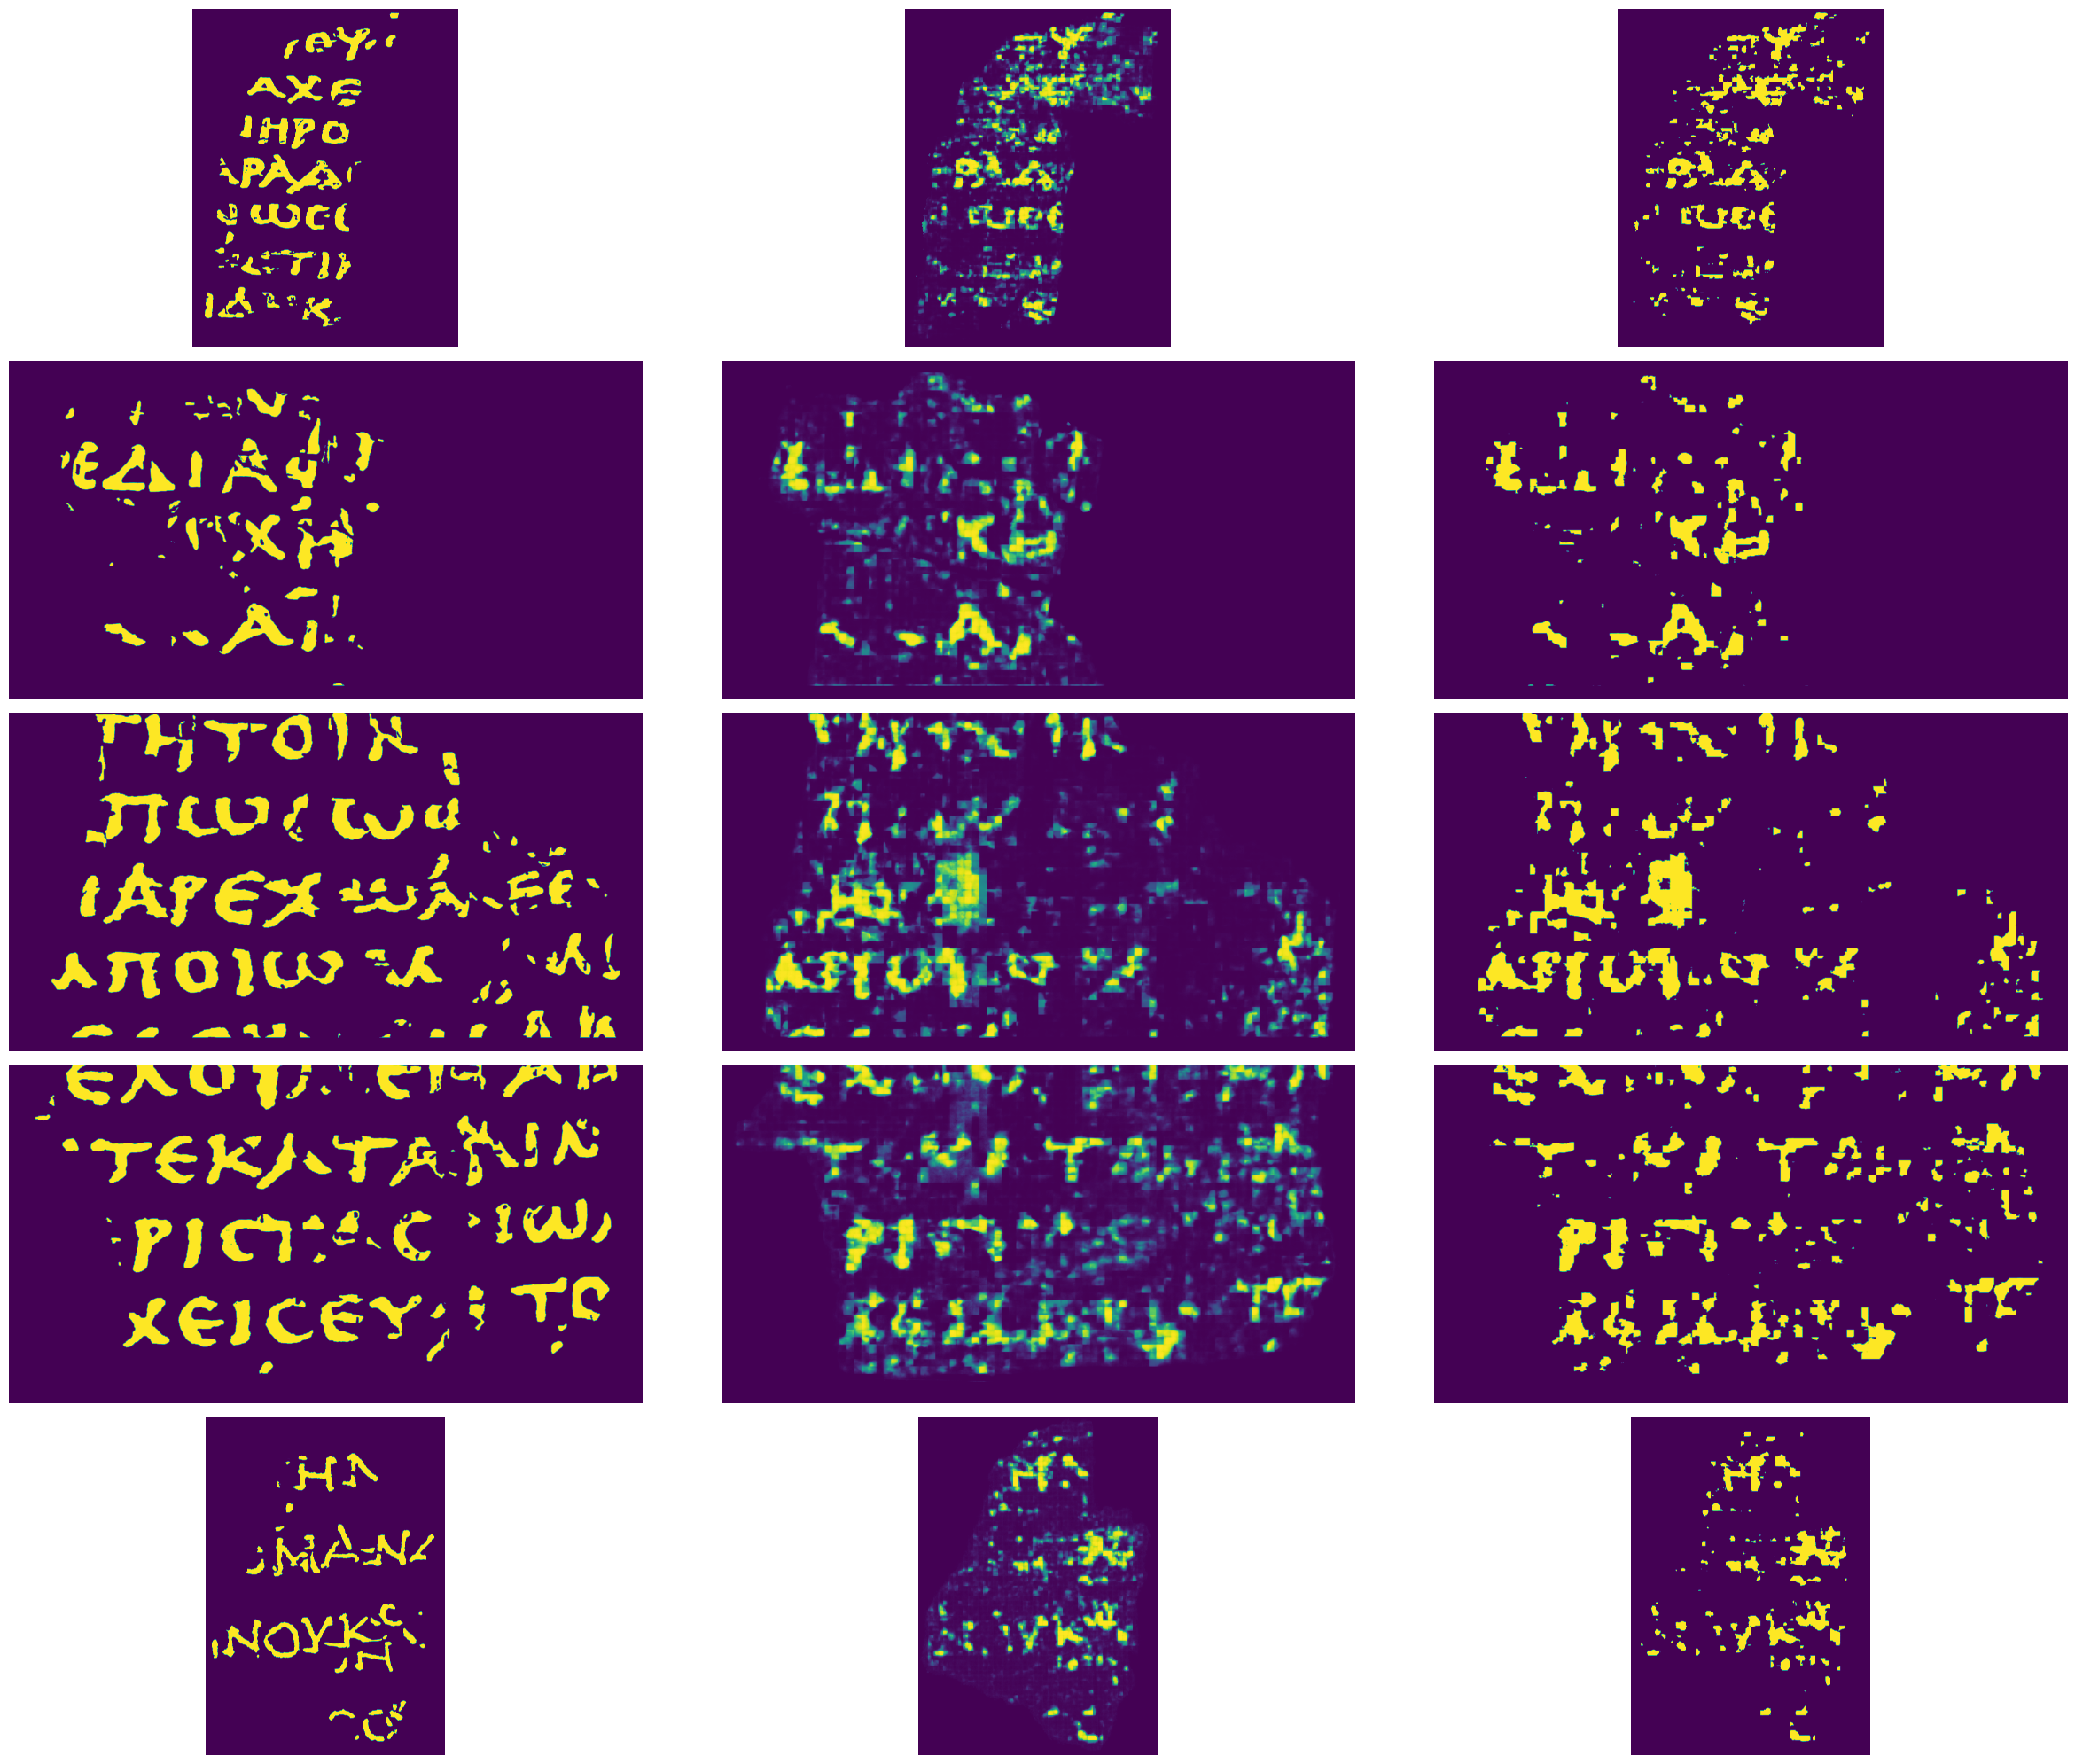

In [11]:
plot_inference(valid_label_gt_list, label_pred_list, CFG)